In [ ]:
import pandas as pd
from torch import nn,optim
import torch
from sklearn import  metrics
from matplotlib import pyplot as plt
from sklearn import preprocessing as prep
from torch.utils.data import TensorDataset,DataLoader,Dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import re

In [62]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df=df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df=df.rename(columns={"v1":'label_num',"v2":'text'})
le= LabelEncoder()
df['label_num']= le.fit_transform(df['label_num'])
df.head()

,label_num,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**tokenized dataset**

In [ ]:
def tokenize(text):
    tokens=[]
    for line in text:
        # line = re.sub(r'[^a-z0-9\s]', '', line)
        line= re.sub(r'[^A-Za-z0-9]+', ' ', line)
        tokens.append(line.lower().split())
    return tokens

doc= df['text'].astype(str).tolist()   
doc_tokens= tokenize(doc)
print(len(doc_tokens))
print(doc[1],'\n',doc_tokens[1])

5572
Ok lar... Joking wif u oni... 
 ['ok', 'lar', 'joking', 'wif', 'u', 'oni']


**Create vacabulary**

In [ ]:
def create_vocabulary(doc_tokens,vocab_size=5000):
    # first find most frequent words in vocabulary
    word_freq = {}
    for tokens in doc_tokens:
        for token in tokens:
            if token in word_freq and token.isalpha():
                word_freq[token] += 1
            else:
                word_freq[token] = 1
    # sort words by frequency
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    most_frequent_words = [word for word, freq in sorted_words[:vocab_size]]

    vocab=most_frequent_words

    word2idx= {w: i+1 for i, w in enumerate(vocab)}
    word2idx['<UNK>']=0
    vocab_size+=1
    return vocab,word2idx,vocab_size

vocab,word2idx,vocab_size= create_vocabulary(doc_tokens,vocab_size=5000)

print(vocab_size)
# word2idx

5001


**define bow vectorizer**

In [65]:
def vectorize_bow(tokens, vocab2idx, vocab_size):
    feature= np.zeros((len(tokens), vocab_size), dtype=np.float64)
    for i, token in enumerate(tokens):
        for j, word in enumerate(token):
            if word in vocab2idx:
                feature[i,vocab2idx[word]]+=1
            else:   
                feature[i,vocab2idx['<UNK>']]+=1
    return feature

**devide tokenized comments into train and test sets**

In [66]:
Xtrain, Xtest, y_train, y_test = train_test_split(doc_tokens, 
                                                df["label_num"].values, 
                                                test_size=0.2, 
                                                random_state=42)

Xtrain, Xvalid, y_train, y_valid = train_test_split(Xtrain,y_train, 
                                                    test_size=0.15, 
                                                    random_state=42)

print(len(Xtrain), len(Xvalid), len(Xtest))
print(np.unique(y_train, return_counts=True))

3788 669 1115
(array([0, 1]), array([3274,  514], dtype=int64))


**define customdataset**

In [67]:
class CustomDataset(Dataset):
    def __init__(self,comments, labels,vocab_size,word2idx):
        self.tokenized_comments=comments
        self.y= labels
        self.vocab_size= vocab_size
        self.word2idx= word2idx
    def __len__(self):
        return len(self.tokenized_comments)

    def __getitem__(self, idx):
        tokens= self.tokenized_comments[idx]
        x= vectorize_bow([tokens], self.word2idx, self.vocab_size)
        y= self.y[idx]
        x= torch.tensor(x, dtype=torch.float32).squeeze(0)
        y= torch.tensor(y, dtype=torch.long)
        return x,y

**create Customdataset for train and test data**

In [68]:
ds_train= CustomDataset(Xtrain, y_train,vocab_size,word2idx)
ds_valid= CustomDataset(Xvalid, y_valid,vocab_size,word2idx)
ds_test= CustomDataset(Xtest, y_test,vocab_size,word2idx)

**create dataloader**

In [69]:
# create DataLoader for batching
train_loader = DataLoader(ds_train, batch_size=128, shuffle=True)
valid_loader = DataLoader(ds_valid, batch_size=128, shuffle=False)
test_loader = DataLoader(ds_test, batch_size=128, shuffle=False)

**define Neural Network Structure**

In [70]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

**create model, optimizer, and cost funtion**

In [71]:
model = MLP(input_size=vocab_size,
            hidden_size=32,
            num_classes=2)

# optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**train model**

In [72]:
num_epochs = 10
train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_acc = correct_train / total_train

    # Validation
    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            valid_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_valid += (predicted == batch_y).sum().item()
            total_valid += batch_y.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    valid_acc = correct_valid / total_valid

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

Epoch [1/10], Train Loss: 0.6012, Train Acc: 0.6872, Valid Loss: 0.4251, Valid Acc: 0.9402
Epoch [2/10], Train Loss: 0.3156, Train Acc: 0.9554, Valid Loss: 0.2277, Valid Acc: 0.9731
Epoch [3/10], Train Loss: 0.1592, Train Acc: 0.9857, Valid Loss: 0.1467, Valid Acc: 0.9746
Epoch [4/10], Train Loss: 0.0929, Train Acc: 0.9913, Valid Loss: 0.1150, Valid Acc: 0.9791
Epoch [5/10], Train Loss: 0.0618, Train Acc: 0.9942, Valid Loss: 0.1019, Valid Acc: 0.9806
Epoch [6/10], Train Loss: 0.0440, Train Acc: 0.9958, Valid Loss: 0.0948, Valid Acc: 0.9806
Epoch [7/10], Train Loss: 0.0326, Train Acc: 0.9968, Valid Loss: 0.0916, Valid Acc: 0.9821
Epoch [8/10], Train Loss: 0.0248, Train Acc: 0.9976, Valid Loss: 0.0902, Valid Acc: 0.9821
Epoch [9/10], Train Loss: 0.0194, Train Acc: 0.9989, Valid Loss: 0.0896, Valid Acc: 0.9821
Epoch [10/10], Train Loss: 0.0156, Train Acc: 0.9992, Valid Loss: 0.0900, Valid Acc: 0.9821


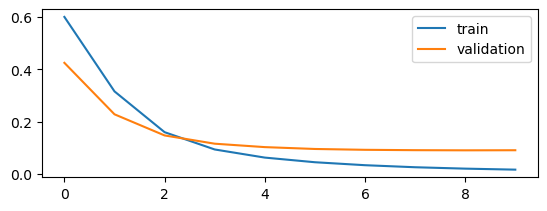

In [73]:
plt.subplot(2,1,1)
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend({'train','validation'})
plt.show()

**test model** 

In [74]:
model.eval()
y_pred=[]
y_true=[]
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        # outputs_p= torch.softmax(outputs,dim=1)
        _, predicted = torch.max(outputs.data, 1)
        
        y_pred.extend(predicted.numpy())
        y_true.extend(batch_y.numpy())

**evaluate model**

Accuracy: 98.0269%
Percision: 97.7612%
Recall: 87.3333%
F1-score: 92.2535%


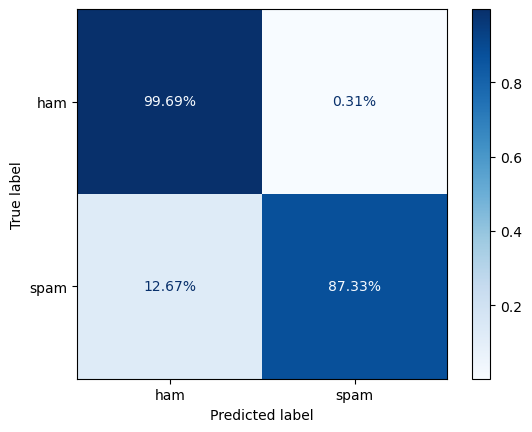

In [75]:
accuracy = metrics.accuracy_score(y_true, y_pred)*100
precision = metrics.precision_score(y_true, y_pred)*100
recall = metrics.recall_score(y_true, y_pred)*100
f1 = metrics.f1_score(y_true, y_pred)*100
print(f'Accuracy: {accuracy:.4f}%')
print(f'Percision: {precision:.4f}%')
print(f'Recall: {recall:.4f}%')
print(f'F1-score: {f1:.4f}%')
cm = metrics.confusion_matrix(y_true, y_pred, normalize='true')
# display normalized confusion matrix with %
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                       display_labels=le.classes_)
# normalized confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                       display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.2%')
plt.show()